# Creating and testing a Feed forward neural network from scratch

## Creating feedforward neural network layers (dense layer)


In [2]:
import numpy as np
from tqdm import tqdm
from math import sqrt

class Layer:
    def __init__(self, input_size, output_size, activation_function, activation_derivative, optimizer):
        self.input_size = input_size
        self.output_size = output_size
        # Initialize weights with small random values (can use Xavier or He initialization later)
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(1.0 / input_size)
        self.biases = np.zeros((1, output_size))  # Better to initialize biases as zeros

        self.activation_function = activation_function
        self.activation_derivative = activation_derivative
        self.optimizer = optimizer

    def forward(self, X):
        self.input = X
        self.z = np.dot(X, self.weights) + self.biases  # Pre-activation value (z)
        self.output = self.activation_function(self.z)
        return self.output

    def backward(self, output_error):
        # Derivative of the activation function applied to the layer's output
        activation_error = output_error * self.activation_derivative(self.output)
        
        # Gradient with respect to input (to propagate backwards)
        input_error = np.dot(activation_error, self.weights.T)
        
        # Gradient with respect to weights and biases
        weights_grad = np.dot(self.input.T, activation_error)
        biases_grad = np.sum(activation_error, axis=0, keepdims=True)
        
        # Update parameters using the optimizer
        self.weights = self.optimizer.update_weights(self.weights, weights_grad)
        self.biases = self.optimizer.update_biases(self.biases, biases_grad)

        return input_error  # Return input error to propagate to the previous layer

## Create the network itself

In [3]:
class FeedForwardNeuralNetwork:
    def __init__(self, input_size, hidden_layers_sizes, hidden_activation_functions, hidden_derivatives, output_size, output_activation_function, output_derivative, loss_function, loss_derivative, optimizer):
        self.layers = [Layer(input_size, hidden_layers_sizes[0], hidden_activation_functions[0], hidden_derivatives[0], optimizer)]
        for i in range(len(hidden_layers_sizes) - 1):
            self.layers.append(Layer(hidden_layers_sizes[i], hidden_layers_sizes[i + 1], hidden_activation_functions[i + 1], hidden_derivatives[i + 1], optimizer))
        self.layers.append(Layer(hidden_layers_sizes[-1], output_size, output_activation_function, output_derivative, optimizer))
        self.loss_function = loss_function
        self.loss_derivative = loss_derivative
        self.optimizer = optimizer  

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backpropagation(self, X, y):
        # Forward pass
        output = self.forward(X)
        
        # Compute the error and initial loss gradient
        error = self.loss_derivative(y, output)  # This is the gradient of the loss with respect to the output
        
        # Backward pass through all layers
        for layer in reversed(self.layers):
            error = layer.backward(error)
        
        return output  # Output of the forward pass (can be used for other purposes, like logging)

    def train(self, X, y, epochs, batch_size):
        progress_bar = tqdm(range(epochs), desc="Training", leave=True)
        for epoch in progress_bar:
            epoch_loss = 0
            num_batches = 0
            for i in range(0, len(X), batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                
                # Forward pass
                output = self.forward(X_batch)
                
                # Calculate loss before backpropagation
                batch_loss = self.loss_function(y_batch, output)
                epoch_loss += batch_loss
                num_batches += 1
                
                # Backpropagation
                self.backpropagation(X_batch, y_batch)
            
            avg_loss = epoch_loss / num_batches  # Average over the number of batches
            progress_bar.set_postfix({"Loss": f"{avg_loss:.4f}, Learning rate: {self.optimizer.current_learning_rate:.4f}"})

    
    def predict(self, X):
        return self.forward(X)
    
    def summary(self):
        for i, layer in enumerate(self.layers):
            print(f"Layer {i+1}:")
            print(f"  Input size: {layer.input_size}")
            print(f"  Output size: {layer.output_size}")
            print(f"  Activation function: {layer.activation_function.__name__}")
            print(f"  Optimizer: {layer.optimizer.__class__.__name__}")
            print()


## Adding activation functions, their derivatives and a loss function (MSE)

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def linear(x):
    return x

def linear_derivative(x):
    return 1

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mse_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.shape[0]  # Corrected to avoid shape issues


## Creating Adam optimiser with adaptative learning rate

In [5]:
class AdamOptimizer:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, min_lr=1e-6, max_lr=1.0, adapt_factor=0.01, grad_smoothing=0.9):
        self.initial_learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m_weights = {}
        self.v_weights = {}
        self.m_biases = {}
        self.v_biases = {}
        self.t = 0  # Time step
        self.min_lr = min_lr  # Minimum learning rate
        self.max_lr = max_lr  # Maximum learning rate
        self.adapt_factor = adapt_factor  # Factor to control learning rate adaptation

    def _adapt_learning_rate(self, grad):
        # Compute the norm of the gradient
        grad_norm = np.linalg.norm(grad)
        # Adjust learning rate based on smoothed gradient norm
        if grad_norm < 5e-4:
            self.current_learning_rate = max(self.min_lr, self.current_learning_rate / (1 + self.adapt_factor))

    def update_weights(self, weights, grad):
        self.t += 1
        self._adapt_learning_rate(grad)

        if id(weights) not in self.m_weights:
            self.m_weights[id(weights)] = np.zeros_like(weights)
            self.v_weights[id(weights)] = np.zeros_like(weights)

        self.m_weights[id(weights)] = self.beta1 * self.m_weights[id(weights)] + (1 - self.beta1) * grad
        self.v_weights[id(weights)] = self.beta2 * self.v_weights[id(weights)] + (1 - self.beta2) * (grad ** 2)

        m_hat = self.m_weights[id(weights)] / (1 - self.beta1 ** self.t)
        v_hat = self.v_weights[id(weights)] / (1 - self.beta2 ** self.t)

        weights -= self.current_learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

        return weights

    
    def update_biases(self, biases, grad):
        self._adapt_learning_rate(grad)

        if id(biases) not in self.m_biases:
            self.m_biases[id(biases)] = np.zeros_like(biases)
            self.v_biases[id(biases)] = np.zeros_like(biases)

        self.m_biases[id(biases)] = self.beta1 * self.m_biases[id(biases)] + (1 - self.beta1) * grad
        self.v_biases[id(biases)] = self.beta2 * self.v_biases[id(biases)] + (1 - self.beta2) * (grad ** 2)

        m_hat = self.m_biases[id(biases)] / (1 - self.beta1 ** self.t)
        v_hat = self.v_biases[id(biases)] / (1 - self.beta2 ** self.t)

        biases -= self.current_learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

        return biases

## Function that creates a dataset and plots the data

In [35]:

def create_dataset(n_samples=100, noise=0.1, limits=[0, 10]):

    X = np.random.uniform(limits[0], limits[1], size=(n_samples, 2))
    
    # Calculate Z = sin(x + y) with noise
    Z = np.sin(X[:, 0] + X[:, 1])
    Z += np.random.normal(0, noise, Z.shape)  # Add noise
    
    return X, Z.reshape(-1, 1)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d(X, y, title=None, highlight=None):
    # Create a new figure and 3D axis
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')

    # If highlight is provided, separate points inside and outside the circle
    if highlight:
        center, radius = highlight
        distances = np.sqrt((X[:, 0] - center[0]) ** 2 + (X[:, 1] - center[1]) ** 2)
        inside_circle = distances <= radius
        outside_circle = ~inside_circle

        # Plot points outside the circle with reduced opacity
        sc1 = ax.scatter(X[outside_circle, 0], X[outside_circle, 1], y[outside_circle], 
                         c=y[outside_circle], cmap='viridis', alpha=0.05, label='Outside Highlight')

        # Plot points inside the circle with full opacity
        sc2 = ax.scatter(X[inside_circle, 0], X[inside_circle, 1], y[inside_circle], 
                         c=y[inside_circle], cmap='viridis', alpha=1, label='Inside Highlight')
    else:
        # Plot all points using the default colormap if no highlight is provided
        sc = ax.scatter(X[:, 0], X[:, 1], y, c=y, cmap='viridis')

    # Set axis labels
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis (y)')
    
    if title:
        ax.set_title(title)

    # Show legend if highlighting
    if highlight:
        plt.legend()

    # Add color bar
    fig.colorbar(sc1 if highlight else sc, ax=ax, shrink=0.5, aspect=5)

    # Show the plot
    plt.show()


## Create some data with noise

(1000, 2) (1000, 1)


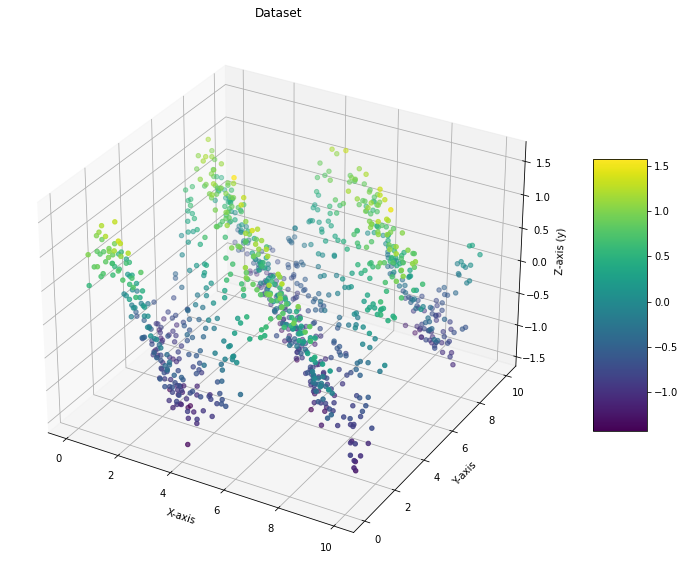

In [36]:

X, y = create_dataset(n_samples=1000, noise=0.2)

X_test, y_test = create_dataset(n_samples=10000, noise=0.2)


print(X.shape, y.shape)
plot_3d(X, y, title="Dataset")


## Create the NN and train it

Layer 1:
  Input size: 2
  Output size: 32
  Activation function: tanh
  Optimizer: AdamOptimizer

Layer 2:
  Input size: 32
  Output size: 32
  Activation function: tanh
  Optimizer: AdamOptimizer

Layer 3:
  Input size: 32
  Output size: 1
  Activation function: linear
  Optimizer: AdamOptimizer



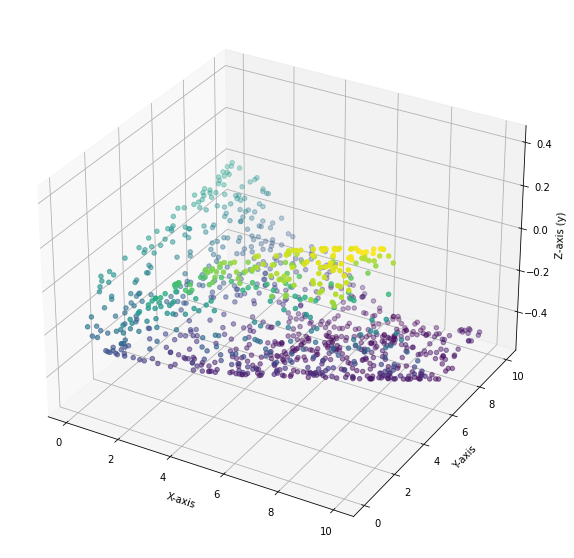

Training: 100%|██████████| 500/500 [00:07<00:00, 70.55it/s, Loss=0.0425, Learning rate: 0.0076]


In [12]:

nnn = FeedForwardNeuralNetwork(
    input_size=2, 
    hidden_layers_sizes=[32, 32],  # Larger hidden layers for capturing complex behavior
    hidden_activation_functions=[tanh, tanh],  # Tanh for smooth function approximation
    hidden_derivatives=[tanh_derivative, tanh_derivative], 
    output_size=1, 
    output_activation_function=linear,  # Linear output
    output_derivative=linear_derivative,  # Derivative of linear activation
    loss_function=mse, 
    loss_derivative=mse_derivative,
    optimizer=AdamOptimizer(learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8)
)

nnn.summary()

plot_3d(X, nnn.predict(X))

nnn.train(X, y, epochs=500, batch_size=64)

## Visualize the predictions

MSE: 0.05295396179356742


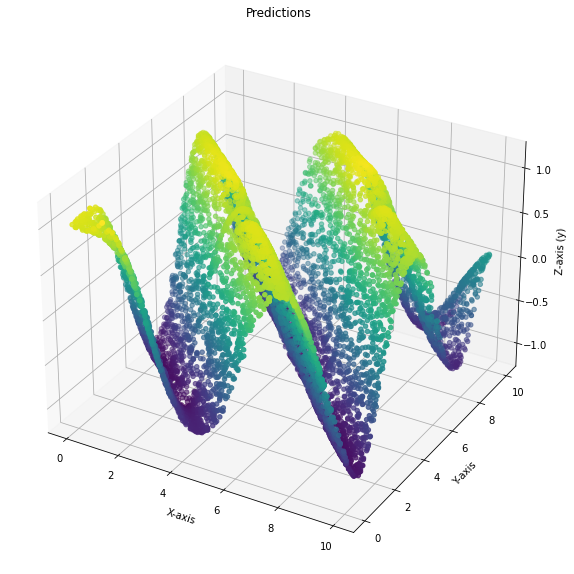

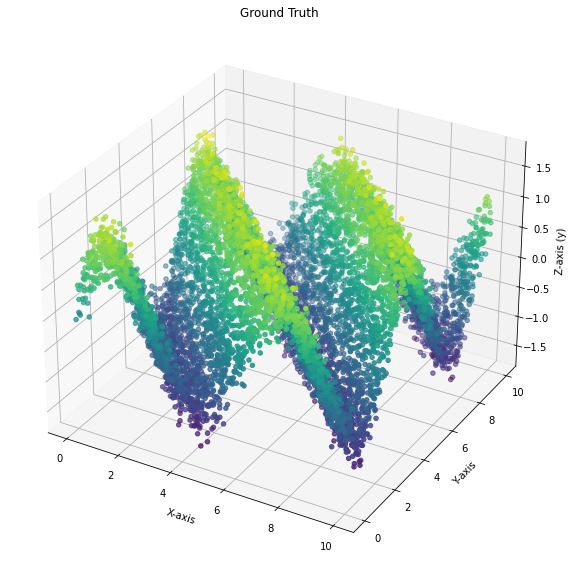

In [13]:
y_pred = nnn.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}")
plot_3d(X_test, y_pred, title="Predictions")
plot_3d(X_test, y_test, title="Ground Truth")

## Test to see the prediction capacity

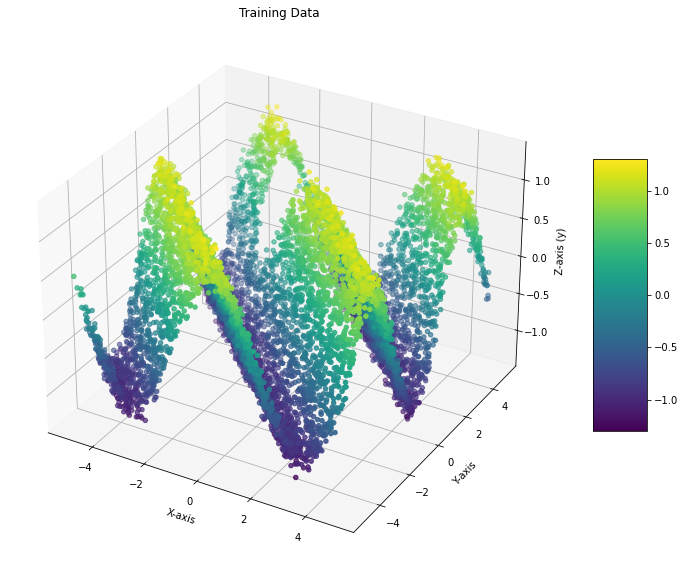

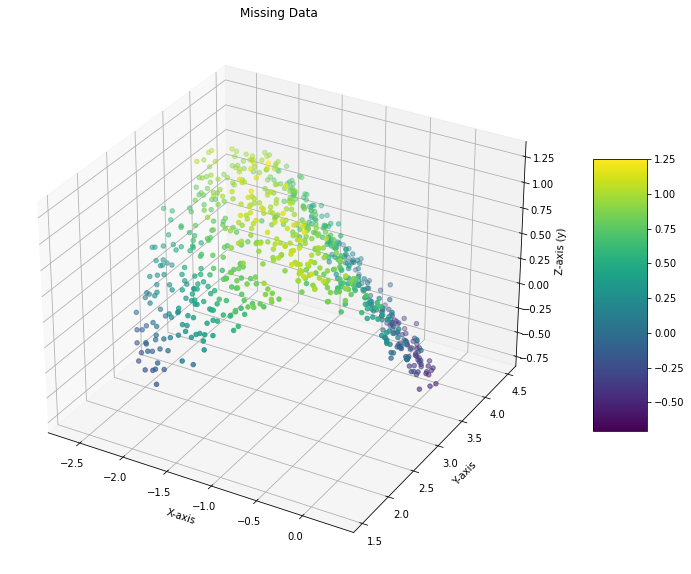

Training: 100%|██████████| 50/50 [00:05<00:00,  9.67it/s, Loss=0.0151, Learning rate: 0.0064]


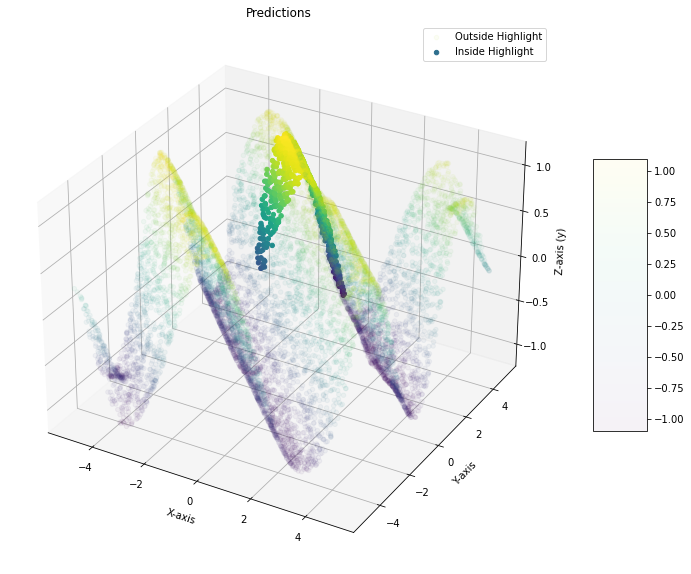

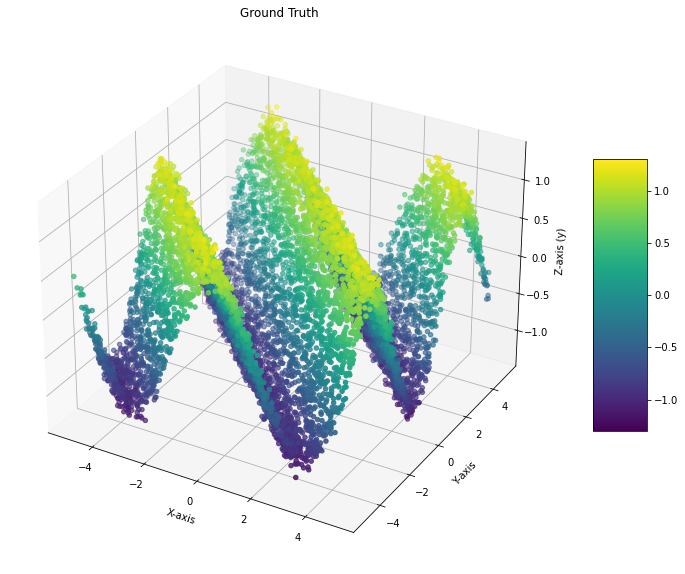

MSE: 0.014796545537692943


In [37]:
## Test to see the prediction capacity

limits = [-5, 5]

X, y = create_dataset(n_samples=10000, noise=0.1, limits=limits)

radius = 1.5
coordinates = np.random.uniform(limits[0]+radius, limits[1]-radius, size=2)

X_missing = X[np.sqrt((X[:, 0] - coordinates[0]) ** 2 + (X[:, 1] - coordinates[1]) ** 2) <= radius]
y_missing = y[np.sqrt((X[:, 0] - coordinates[0]) ** 2 + (X[:, 1] - coordinates[1]) ** 2) <= radius]

X_train = X[np.sqrt((X[:, 0] - coordinates[0]) ** 2 + (X[:, 1] - coordinates[1]) ** 2) > radius]
y_train = y[np.sqrt((X[:, 0] - coordinates[0]) ** 2 + (X[:, 1] - coordinates[1]) ** 2) > radius]

plot_3d(X_train, y_train, title="Training Data")
plot_3d(X_missing, y_missing, title="Missing Data")

nnn = FeedForwardNeuralNetwork(
    input_size=2, 
    hidden_layers_sizes=[32, 32],  # Larger hidden layers for capturing complex behavior
    hidden_activation_functions=[tanh, tanh],  # Tanh for smooth function approximation
    hidden_derivatives=[tanh_derivative, tanh_derivative], 
    output_size=1, 
    output_activation_function=linear,  # Linear output
    output_derivative=linear_derivative,  # Derivative of linear activation
    loss_function=mse, 
    loss_derivative=mse_derivative,
    optimizer=AdamOptimizer(learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, min_lr=1e-6, max_lr=1.0, adapt_factor=0.01, grad_smoothing=0.9)
)

nnn.train(X_train, y_train, epochs=50, batch_size=64)

y_pred = nnn.predict(X)

plot_3d(X, y_pred, title="Predictions", highlight=((coordinates[0], coordinates[1]), radius))
plot_3d(X, y, title="Ground Truth")
print(f"MSE: {mse(y, y_pred)}")